In [6]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import tensorflow as tf
import keras
from keras import ops
from keras import layers

In [7]:
#Load Data
data_dir = Path("./mbbank_biz_captcha_dataset/")
images = sorted(list(map(str, list(data_dir.glob("*.png")))))
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]
characters = set(char for label in labels for char in label)
characters = sorted(list(characters))

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

batch_size = 16

img_width = 200
img_height = 35

downsample_factor = 4
min_length = min([len(label) for label in labels])
max_length = max([len(label) for label in labels])
for label in labels:
    if len(label) != 6:
        print
print(min_length, max_length)

Number of images found:  1993
Number of labels found:  1993
Number of unique characters:  35
Characters present:  ['2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'D', 'E', 'F', 'G', 'H', 'J', 'M', 'N', 'R', 'T', 'Y', 'a', 'b', 'd', 'e', 'f', 'g', 'h', 'j', 'm', 'n', 'q', 'r', 't', 'y']
6 6


In [8]:
#Preprocessing
char_to_num = layers.StringLookup(vocabulary=list(characters), mask_token=None)
num_to_char = layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)

def split_data(images, labels, train_size = 0.7, shuffle = True):
    size = len(images)
    indices = ops.arange(size)
    if shuffle:
        indices = keras.random.shuffle(indices)
    train_samples = int(size * train_size)
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid

x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))

def encode_single_sample(img_path, label):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_png(img, channels = 1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = ops.image.resize(img, [img_height, img_width])
    img = ops.transpose(img, axes=[1, 0, 2])
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    return {"image": img, "label": label}

In [9]:
#Create Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls = tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(buffer_size = tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

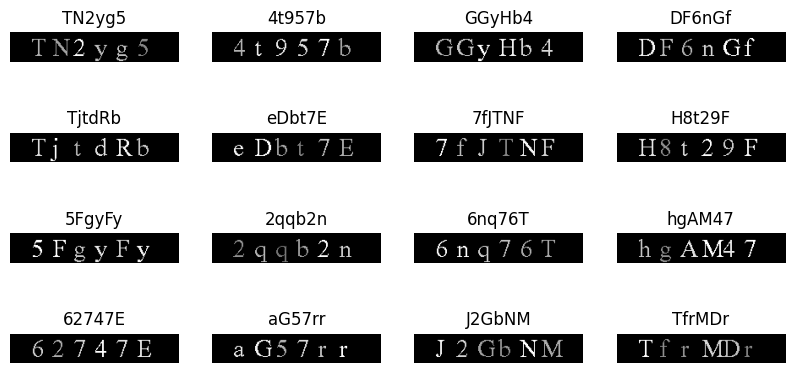

In [10]:
#Visualize Data
_, ax = plt.subplots(4, 4, figsize = (10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("UTF-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap = "gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [11]:
def ctc_batch_cost(y_true, y_pred, input_length, label_length):
    label_length = ops.cast(ops.squeeze(label_length, axis=-1), dtype="int32")
    input_length = ops.cast(ops.squeeze(input_length, axis=-1), dtype="int32")
    sparse_labels = ops.cast(
        ctc_label_dense_to_sparse(y_true, label_length), dtype="int32"
    )

    y_pred = ops.log(ops.transpose(y_pred, axes=[1, 0, 2]) + keras.backend.epsilon())

    return ops.expand_dims(
        tf.compat.v1.nn.ctc_loss(
            inputs=y_pred, labels=sparse_labels, sequence_length=input_length
        ),
        1,
    )


def ctc_label_dense_to_sparse(labels, label_lengths):
    label_shape = ops.shape(labels)
    num_batches_tns = ops.stack([label_shape[0]])
    max_num_labels_tns = ops.stack([label_shape[1]])

    def range_less_than(old_input, current_input):
        return ops.expand_dims(ops.arange(ops.shape(old_input)[1]), 0) < tf.fill(
            max_num_labels_tns, current_input
        )

    init = ops.cast(tf.fill([1, label_shape[1]], 0), dtype="bool")
    dense_mask = tf.compat.v1.scan(
        range_less_than, label_lengths, initializer=init, parallel_iterations=1
    )
    dense_mask = dense_mask[:, 0, :]

    label_array = ops.reshape(
        ops.tile(ops.arange(0, label_shape[1]), num_batches_tns), label_shape
    )
    label_ind = tf.compat.v1.boolean_mask(label_array, dense_mask)

    batch_array = ops.transpose(
        ops.reshape(
            ops.tile(ops.arange(0, label_shape[0]), max_num_labels_tns),
            tf.reverse(label_shape, [0]),
        )
    )
    batch_ind = tf.compat.v1.boolean_mask(batch_array, dense_mask)
    indices = ops.transpose(
        ops.reshape(ops.concatenate([batch_ind, label_ind], axis=0), [2, -1])
    )

    vals_sparse = tf.compat.v1.gather_nd(labels, indices)

    return tf.SparseTensor(
        ops.cast(indices, dtype="int64"), 
        vals_sparse, 
        ops.cast(label_shape, dtype="int64")
    )


class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = ops.cast(ops.shape(y_true)[0], dtype="int64")
        input_length = ops.cast(ops.shape(y_pred)[1], dtype="int64")
        label_length = ops.cast(ops.shape(y_true)[1], dtype="int64")

        input_length = input_length * ops.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * ops.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred


def build_model():
    # Inputs to the model
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # First conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model


# Get the model
model = build_model()
model.summary()

Model: "ocr_model_v1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 200, 35,   │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 200, 35,   │        320 │ image[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 100, 17,   │          0 │ Conv1[0][0]       │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2 (Conv2D)      │ (None, 100, 17,   │     18,496 │ pool1[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool2               │ (None, 50, 8, 64) │          0 │ Conv2[0][0]       │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 50, 512)   │          0 │ pool2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense1 (Dense)      │ (None, 50, 64)    │     32,832 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 50, 64)    │          0 │ dense1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 50, 256)   │    197,632 │ dropout[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 50, 128)   │    164,352 │ bidirectional[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label (InputLayer)  │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense2 (Dense)      │ (None, 50, 37)    │      4,773 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ctc_loss (CTCLayer) │ (None, 50, 37)    │          0 │ label[0][0],      │
│                     │                   │            │ dense2[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 418,405 (1.60 MB)

 Trainable params: 418,405 (1.60 MB)

 Non-trainable params: 0 (0.00 B)

In [99]:
#Training
epochs = 100
early_stopping_patience = 10

early_stopping = keras.callbacks.EarlyStopping(
    monitor = "val_loss", patience = early_stopping_patience, restore_best_weights=True
)

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping]
)

Epoch 1/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - loss: 722.0870 - val_loss: 368.3815
Epoch 2/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 370.2372 - val_loss: 368.0500
Epoch 3/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 369.5558 - val_loss: 367.1327
Epoch 4/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 368.1065 - val_loss: 362.3395
Epoch 5/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 362.4671 - val_loss: 356.8534
Epoch 6/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 358.6193 - val_loss: 355.8253
Epoch 7/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 357.4385 - val_loss: 352.2298
Epoch 8/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 353.0449 - val_loss: 345.4078
Epoch 9/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 347.0164 - val_loss: 340.1644
Epoch 10/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 341.5979 - val_loss: 336.3065
Epoch 11/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 336.2752 - val_loss: 329.6462
Epoch 12

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 200, 35, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1 (Conv2D)                  │ (None, 200, 35, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 100, 17, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2 (Conv2D)                  │ (None, 100, 17, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 50, 8, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 50, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 50, 64)         │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 50, 256)        │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 50, 128)        │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 50, 37)         │         4,773 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 418,405 (1.60 MB)

 Trainable params: 418,405 (1.60 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


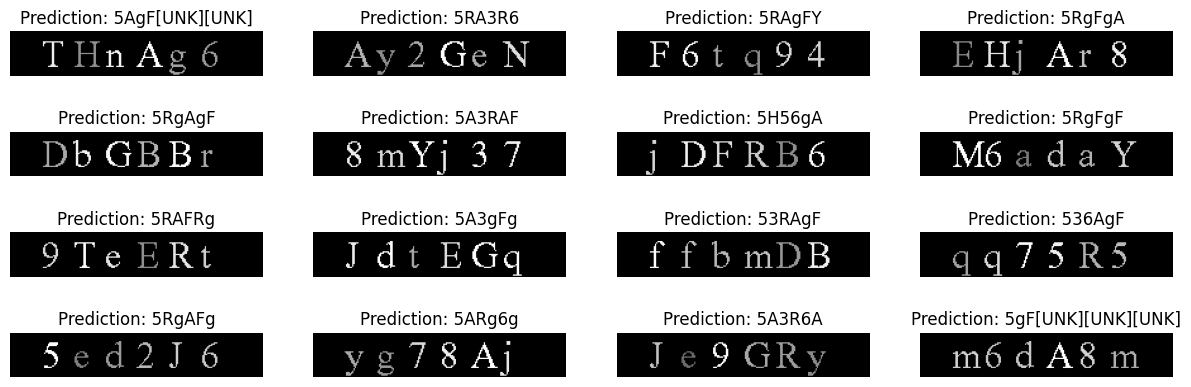

In [12]:
def ctc_decode(y_pred, input_length, greedy=True, beam_width=100, top_paths=1):
    input_shape = ops.shape(y_pred)
    num_samples, num_steps = input_shape[0], input_shape[1]
    y_pred = ops.log(ops.transpose(y_pred, axes=[1, 0, 2]) + keras.backend.epsilon())
    input_length = ops.cast(input_length, dtype="int32")

    if greedy:
        (decoded, log_prob) = tf.nn.ctc_greedy_decoder(
            inputs=y_pred, sequence_length=input_length
        )
    else:
        (decoded, log_prob) = tf.compat.v1.nn.ctc_beam_search_decoder(
            inputs=y_pred,
            sequence_length=input_length,
            beam_width=beam_width,
            top_paths=top_paths,
        )
    decoded_dense = []
    for st in decoded:
        st = tf.SparseTensor(st.indices, st.values, (num_samples, num_steps))
        decoded_dense.append(tf.sparse.to_dense(sp_input=st, default_value=-1))
    return (decoded_dense, log_prob)


# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.input[0], model.get_layer(name="dense2").output
)
prediction_model.summary()


# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some validation samples
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [101]:
prediction_model.save('my_model.keras')

In [13]:
from keras.models import load_model
prediction_model = load_model("my_model.keras")

print(prediction_model.summary())

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 200, 35, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1 (Conv2D)                  │ (None, 200, 35, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 100, 17, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2 (Conv2D)                  │ (None, 100, 17, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 50, 8, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 50, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 50, 64)         │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_16                │ (None, 50, 256)        │       197,632 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_17                │ (None, 50, 128)        │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 50, 37)         │         4,773 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 418,405 (1.60 MB)

 Trainable params: 418,405 (1.60 MB)

 Non-trainable params: 0 (0.00 B)

None


In [15]:
from PIL import Image
test_dir = Path("./mbbank_biz_captcha_dataset/")
images = sorted(list(map(str, list(test_dir.glob("*.png")))))

def preprocess_image(image):
    # Normalize pixel values and expand dimensions to include batch size
    image = np.expand_dims(image, axis=0)
    return image

def encode_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_png(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = ops.image.resize(img, [img_height, img_width])
    img = ops.transpose(img, axes=[1, 0, 2])
    return img

encoded_images = list(map(encode_image, images))
print(encoded_images[0].shape)
preprocessed_images = list(map(preprocess_image, encoded_images))
print(preprocessed_images[0].shape)
def decode_prediction(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, :max_length]
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text[0]

for idx, image in enumerate(preprocessed_images):
    print(f"Image {idx} shape: {image.shape}")
    pred = prediction_model.predict(image)
    pred_text = decode_batch_predictions(pred)
    final_image = ops.transpose(image, axes=[0, 2, 1, 3])
    pil_image = Image.fromarray((final_image[0].numpy() * 255).astype(np.uint8).squeeze())
    
    # Save the image with the predicted text as the filename
    save_path = os.path.join("predicted_image", f'{idx}_{pred_text}.png')
    pil_image.save(save_path)
    print(f'Saved CAPTCHA image: {save_path}')

(200, 35, 1)
(1, 200, 35, 1)
Image 0 shape: (1, 200, 35, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Saved CAPTCHA image: predicted_image\0_['222B2R'].png
Image 1 shape: (1, 200, 35, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Saved CAPTCHA image: predicted_image\1_['22EB[UNK][UNK]'].png
Image 2 shape: (1, 200, 35, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Saved CAPTCHA image: predicted_image\2_['245FRJ'].png
Image 3 shape: (1, 200, 35, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Saved CAPTCHA image: predicted_image\3_['248EEY'].png
Image 4 shape: (1, 200, 35, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Saved CAPTCHA image: predicted_image\4_['24raDB'].png
Image 5 shape: (1, 200, 35, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Saved CAPTCHA image: predicted_image\5_['25btaM'].png
Image 6 shape: (1, 200, 35, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Saved CAPTCHA image: predicted_image\6_['25rrrf'].png
Image 7 shape: (1, 200, 35, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Saved CAPTCHA image: predicted_im